# DeepFool ATTACK

In [ ]:
!pip install facenet-pytorch
!pip install Pillow
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]
!pip install matplotlib

### *Import*



### initialization

In [1]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)

c:\Users\cassd\miniconda3\envs\ai4cyber\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    resnet = inception.InceptionResnetV1(pretrained='vggface2').eval()
    resnet.classify = True
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    resnet.classify = True

Import Inception.Inception


In [5]:
resnet.classify = True
resnet.to(device)
fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

In [8]:
def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    tns.to(device)
    return tns
model = PyTorchClassifier(resnet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


### Untargeted Attack on all test set

In [9]:
from art.attacks.evasion import DeepFool
import os
import re
from utils import load_image_NN1

dataset_dir = "test_set_cropped_piccolo/" 
eps_range = [1e-09, 1e-07,  1e-05, 1e-03, 1e-02, 1e00] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.

max_iter = 5  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
 
accuracy_for_eps = []
perturbation_for_eps = []
correct_predictions = 0
total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")

    
for eps in eps_range:   
    correct_predictions = 0
    total_images = 0
    perturbation = []        
    attack = DeepFool(classifier=classifier, epsilon=eps, max_iter=max_iter)
            
    print("**** Attacco con eps:{} ****".format(eps))
    for filename in os.listdir(dataset_dir):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            person_path = os.path.join(dataset_dir, filename)
            test_img = load_image_NN1(person_path)
            test_img  = test_img.numpy()
            test_images_adv = attack.generate(test_img)
            model_predictions = model.predict(test_images_adv)
            correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
            #print("Etichetta corretta:", correct_label)   
            perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
            predicted_label = LABELS[np.array(model_predictions[0].argmax())]
            #print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
            total_images+=1
            predicted_label = str(predicted_label)

            if correct_label in predicted_label:
                correct_predictions+=1

                #accuracy = correct_predictions/total_images
                #print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
            

    if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
        if len(perturbation) == total_images:
            perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
            perturbation_for_eps.append(perturbazione_media)
            #print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(eps,perturbazione_media))

            final_accuracy = correct_predictions/total_images
            accuracy_for_eps.append(final_accuracy)
            #print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(eps,final_accuracy))
        #print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")


Inizio Attacco DeepFool NON-TARGETED
**** Attacco con eps:1e-09 ****


DeepFool: 100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


**** Attacco con eps:1e-07 ****


DeepFool: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


**** Attacco con eps:1e-05 ****


DeepFool: 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


**** Attacco con eps:0.001 ****


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]


**** Attacco con eps:0.01 ****


DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


**** Attacco con eps:1.0 ****


DeepFool: 100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


In [10]:
print(accuracy_for_eps)
print(perturbation_for_eps)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.0]
[0.0015252451063133775, 0.0015252442739438266, 0.0015252684679580852, 0.0015267795970430598, 0.0015405084355734288, 0.003050513088237494]


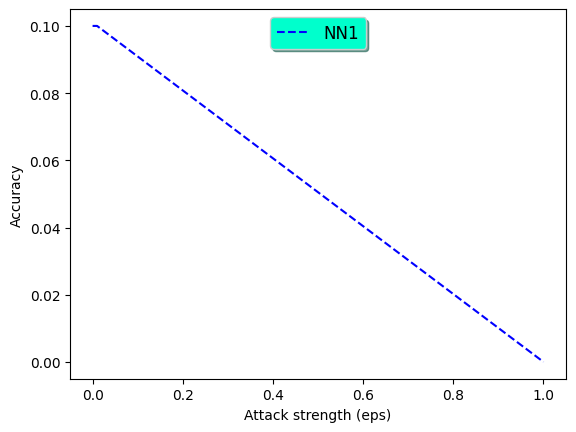

In [11]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(accuracy_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

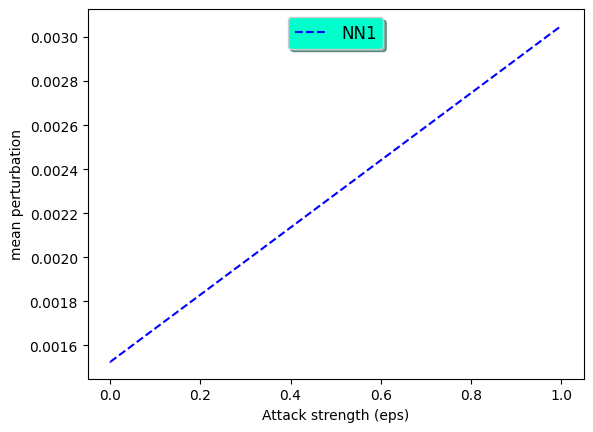

In [12]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(perturbation_for_eps), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

### Single sample Untargeted attack

In [13]:
from art.attacks.evasion import DeepFool

epsilon = 0.1
max_iter = 10

attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

In [14]:
from utils import load_image_NN1
dataset_dir = "test_set_cropped/"
filename = "Brad_Pitt_8_face_0.jpg"

person_path = os.path.join(dataset_dir, filename)
test_img = load_image_NN1(person_path)
test_img_numpy  = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)
model_predictions = model.predict(test_images_adv)
predicted_label = LABELS[np.array(model_predictions[0].argmax())]
print(predicted_label)


DeepFool: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

 Josh_Hartnett


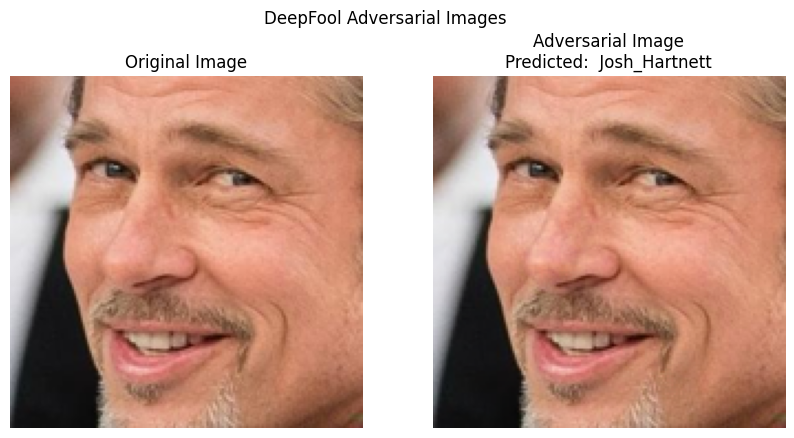

In [15]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()
